# Project 5 - 02 : Models

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
import joblib
import matplotlib.colors as mcolors
import nltk
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from random import shuffle
from scipy.sparse import vstack
from sklearn import decomposition
from gensim.matutils import Sparse2Corpus
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, LdaMulticore, CoherenceModel, TfidfModel
from gensim.models.nmf import Nmf
from wordcloud import WordCloud
from skmultilearn.problem_transform import ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, jaccard_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

DISPLAY_LDA_VISU = False

C:\Users\Flooow\anaconda3\envs\OC_IML_P5\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
# adding Folder_2 to the system path
import sys
sys.path.insert(0, r"D:\Documents\_Cours\_FormationOC_IngénieurML\Projet5\P5_StackOverflow\P5_03_API\app\core")
  
# importing the add and odd_even 
# function
from transform_tokenizer import TransformTokenizer

test = TransformTokenizer()
type(test)

transform_tokenizer.TransformTokenizer

Due to some issue with the API (P5_03_API) when loading the vectorizers, I'm using the TransformTokenizer class from the API to create vectorizers in this notebook

In [3]:
%load_ext pycodestyle_magic
%flake8_on --max_line_length 150

## Data import

Duplication of the class used by vectorizers

In [4]:
# load data
corpus_df = joblib.load("P5_04_data/dataset.pkl")
# load vectorizers
corpus_voc, bow_vectorizer, tfidf_vectorizer = joblib.load("P5_04_data/fitted-vectorizers.pkl")
try:
    # load method1 objects
    voc_gensim, dtm_gensim, tfidf_gensim = joblib.load("P5_04_data/gensim_voc-dt-tfidf.pkl")
    lda_model_gensim = joblib.load("P5_04_data/gensim-lda.pkl")
    nmf_model_gensim = joblib.load("P5_04_data/gensim-nmf.pkl")
    # load method2 objects
    train_tfidf_vectorizer, mlb_tags = joblib.load("P5_04_data/trainset-io-vectorizers.pkl")
    print("Files loaded")
except FileNotFoundError as e:
    print(e)
except Exception as e:
    raise e

Files loaded


## Method 1 : unsupervised approach

#### LDA

### Topic Modeling
Topic modelling aims to automatically discover the hidden thematic structure in a large corpus of text documents. 

**Baseline**

In [6]:
k_topics = 10  # Number of topics to gener. Arbitrary set in a first place

In [7]:
lda_model_sklearn = decomposition.LatentDirichletAllocation(
    n_components=k_topics,
    max_iter=5,
    learning_method='online',
    learning_offset=50.,
    random_state=0)

lda_model_sklearn.fit(vstack(corpus_df['bow']))

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [8]:
def get_topics_descriptor(model, voc, descriptor_len=10, display=True):
    """ Display the most representative words of the modeled subjects
    args:
        model: sklearn.decomposition model
        feature_names: list(str) - corpus vocabulary
        descr_len: int - Number of terms in the descriptor
        display: bool, optionnal default=True - print the topics descriptors if True
    """
    if display:
        print(f"{descriptor_len} words descriptor of the {k_topics} topics (using {model.__class__.__name__}):\n")
    topic_descr = {}
    for topic_idx, topic in enumerate(model.components_):
        descriptor = [voc[i] for i in topic.argsort()[:-descriptor_len-1:-1]]
        topic_descr[topic_idx+1] = descriptor
        if display:
            print(f"Topic {topic_idx+1:02d}: {', '.join(descriptor)}")

In [9]:
lda_topics_descr = get_topics_descriptor(lda_model_sklearn, corpus_voc, 10, True)

10 words descriptor of the 10 topics (using LatentDirichletAllocation):

Topic 01: view, app, android, self, import, id, device, com, button, io
Topic 02: java, com, apache, version, spring, org, class, jar, dependency, springframework
Topic 03: int, class, function, return, type, code, value, string, std, array
Topic 04: file, error, package, line, module, py, version, lib, docker, command
Topic 05: class, div, component, button, form, page, style, function, input, value
Topic 06: image, spark, output, print, list, range, time, import, array, def
Topic 07: model, item, flutter, child, return, class, map, layer, list, package
Topic 08: data, value, name, column, id, row, date, time, df, group
Topic 09: error, http, request, app, user, service, log, client, server, response
Topic 10: color, size, var, position, text, image, line, bar, point, plot


In [10]:
def plot_top_term_weights(voc, weights, topic_idx, top, model_name):
    """ Display a bar plot of the top ranked terms for a given topic
    args:
        voc: list(str) - corpus vocabulary
        weights: ndarray - the term weights relative to each of the k topics
        topic_idx : int - index of the topic
        top: int - Number of terms to display
    """
    # get the top terms and their weights
    top_indices = np.argsort(weights[topic_idx, :])[::-1]
    top_terms = []
    top_weights = []
    for term_idx in top_indices[0:top]:
        top_terms.append(voc[term_idx])
        top_weights.append(weights[topic_idx, term_idx])
    # reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    f, ax = plt.subplots(figsize=(10, 5))
    ypos = np.arange(top)
    ax.barh(ypos, top_weights, align="center", color="#19baff", tick_label=top_terms)
    plt.xlabel("Term Weight", fontsize=14)
    plt.title(f"Top {top} terms in the Topic {topic_idx+1:02d} ({model_name})")
    f.tight_layout()
    plt.show()

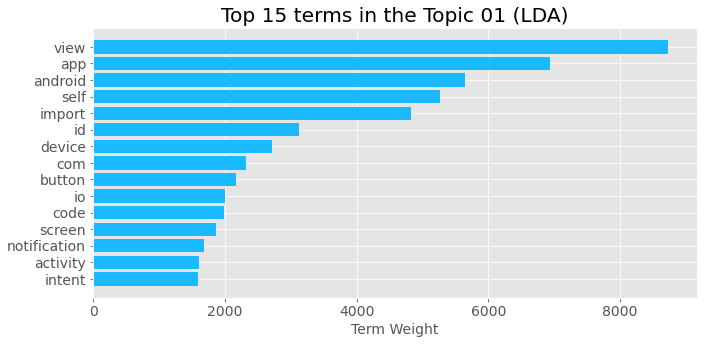

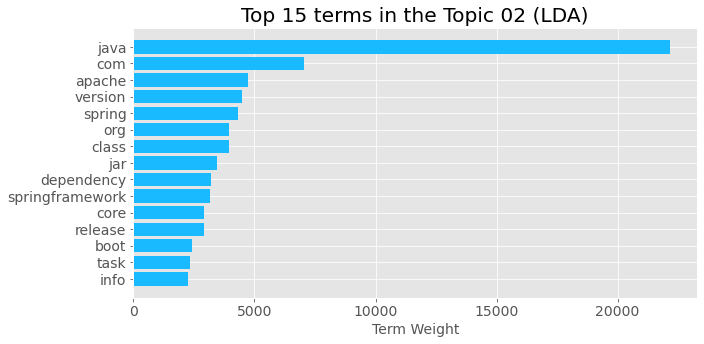

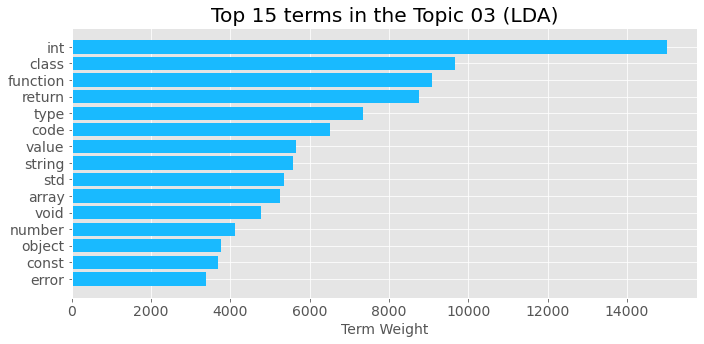

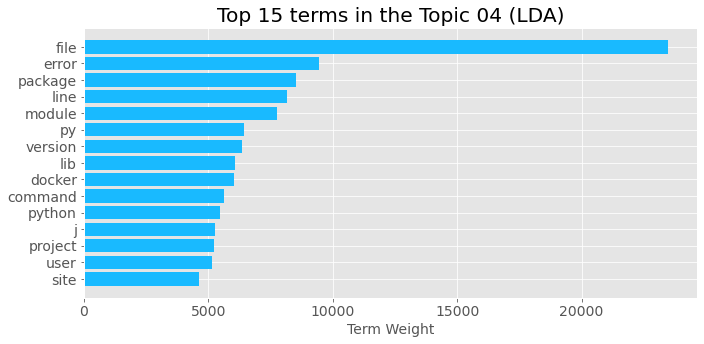

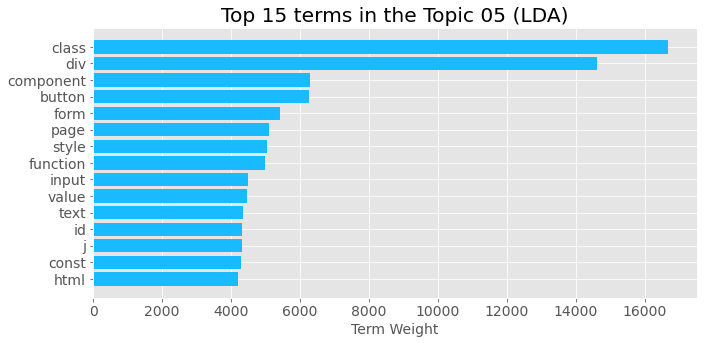

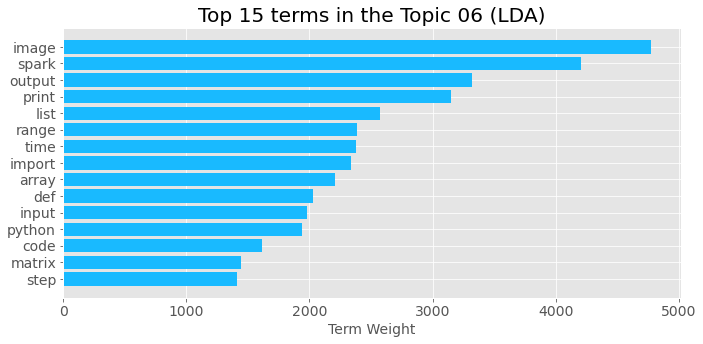

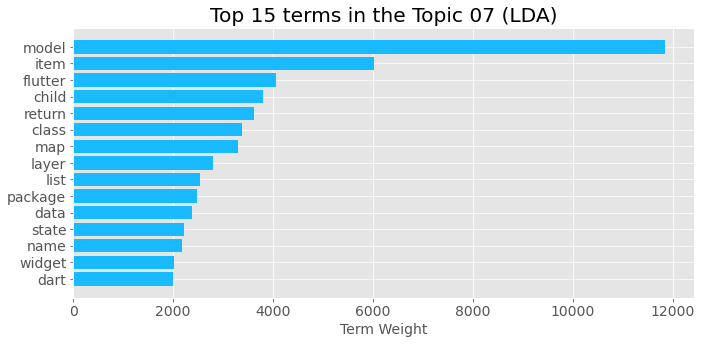

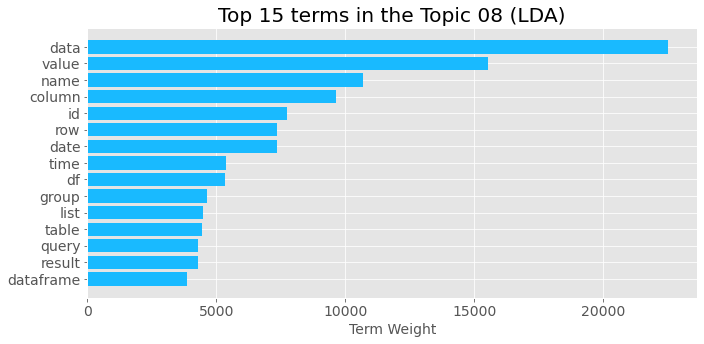

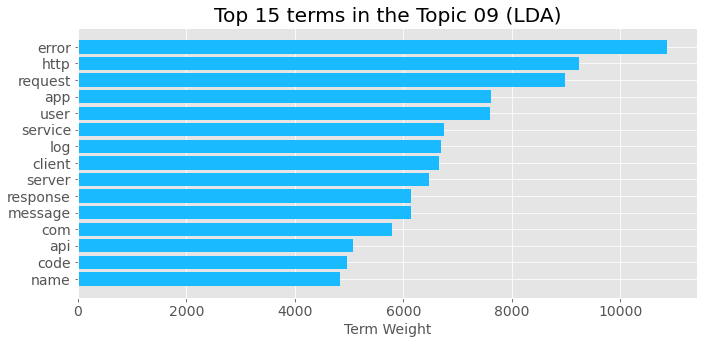

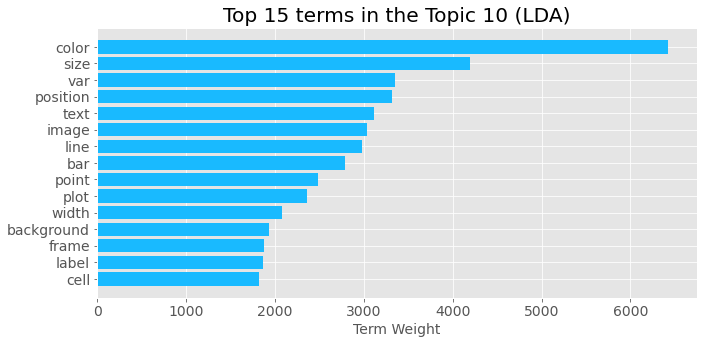

In [11]:
for i in range(k_topics):
    plot_top_term_weights(corpus_voc, lda_model_sklearn.components_, i, 15, 'LDA')

After making the reference model with scikit-learn, I discovered the gensim library, specializing in topic modeling, with a lot of interesting features, especially for the evaluation of models and visualization of detected topics

In [12]:
# compute document-term matrix from gensim
dtm_gensim = Sparse2Corpus(vstack(corpus_df['bow']), documents_columns=False)
# compute tfidf matrix from gensim
tfidf_gensim = Sparse2Corpus(vstack(corpus_df['tfidf']), documents_columns=False)

voc_gensim = Dictionary.from_corpus(dtm_gensim, id2word=dict((id, word) for word, id in bow_vectorizer.vocabulary_.items()))
# saving
joblib.dump((voc_gensim, dtm_gensim, tfidf_gensim), "P5_04_data/gensim_voc-dt-tfidf.pkl")

['P5_04_data/gensim_voc-dt-tfidf.pkl']

In [13]:
lda_params = {
    'corpus': dtm_gensim,
    'id2word': voc_gensim,
    'random_state': 0,
    'chunksize': 100,
    'per_word_topics': True
}
# baseline model
lda_model_gensim = LdaMulticore(num_topics=k_topics, **lda_params)

In [14]:
# Compute Perplexity
print('Perplexity: ', lda_model_gensim.log_perplexity(dtm_gensim))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model_gensim,
    # using inverse_transform() to get the reduced list of tokens
    texts=bow_vectorizer.inverse_transform(vstack(corpus_df['bow'])),
    dictionary=voc_gensim,
    coherence='c_v',
    processes=-1
)
print('Coherence Score: ', coherence_model_lda.get_coherence())

Perplexity:  -7.447481620823484
Coherence Score:  0.6460109977082925


**Optimal number of topics**

In [15]:
def compute_coherence_values(model_type, model_params, tokens, limit, start=2, step=3):
    """Compute c_v coherence for various number of topics
    args:
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics
    Returns:
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    if 'num_topics' in model_params:
        del model_params['num_topics']
    models = {}
    for num_topics in range(start, limit, step):
        print(f"Testing with {num_topics:02d} topics ...", end=' ')
        if model_type == 'lda':
            model = LdaMulticore(num_topics=num_topics, **model_params)
        elif model_type == 'nmf':
            model = Nmf(num_topics=num_topics, **model_params)
        coherencemodel = CoherenceModel(
            model=model,
            texts=tokens,
            dictionary=model_params['id2word'],
            coherence='c_v',
            processes=-1
        )
        models[num_topics] = {'model': model, 'score': coherencemodel.get_coherence()}
        print(f"coherence = {coherencemodel.get_coherence():.3f}")
    return models

In [16]:
%%time

start = 2
limit = 51  # Number of differents tags + 1
step = 4

lda_models = compute_coherence_values(
    model_type='lda',
    model_params=lda_params,
    tokens=bow_vectorizer.inverse_transform(vstack(corpus_df['bow'])),
    start=start, limit=limit, step=step
)

Testing with 02 topics ... coherence = 0.544
Testing with 06 topics ... coherence = 0.597
Testing with 10 topics ... coherence = 0.640
Testing with 14 topics ... coherence = 0.645
Testing with 18 topics ... coherence = 0.615
Testing with 22 topics ... coherence = 0.608
Testing with 26 topics ... coherence = 0.602
Testing with 30 topics ... coherence = 0.576
Testing with 34 topics ... coherence = 0.566
Testing with 38 topics ... coherence = 0.555
Testing with 42 topics ... coherence = 0.525
Testing with 46 topics ... coherence = 0.534
Testing with 50 topics ... coherence = 0.526
Wall time: 12min 27s


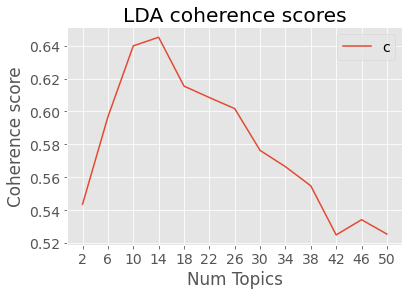

In [17]:
# Show graph
plt.plot(range(start, limit, step), [lda_models[x]['score'] for x in lda_models])
plt.xlabel("Num Topics")
plt.xticks(range(start, limit, 4))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("LDA coherence scores")
plt.show()

In [18]:
best_nbtopics = [x for x in lda_models if lda_models[x]['score'] == max([lda_models[x]['score'] for x in lda_models])][0]
lda_params['num_topics'] = best_nbtopics

In [19]:
print(f"As we can see, the best coherence score is reached with {best_nbtopics}"
      f" topics ({lda_models[best_nbtopics]['score']}) for LDA topic modeling")

As we can see, the best coherence score is reached with 14 topics (0.6451071912105762) for LDA topic modeling


In [20]:
lda_model_gensim = LdaMulticore(**lda_params)
lda_model_gensim = lda_models[best_nbtopics]['model']
print(f"Coherence Score for {best_nbtopics} topics: {lda_models[best_nbtopics]['score']}")

Coherence Score for 14 topics: 0.6451071912105762


In [21]:
joblib.dump(lda_model_gensim, "P5_04_data/gensim-lda.pkl")

['P5_04_data/gensim-lda.pkl']

In [22]:
for topic in lda_model_gensim.print_topics(num_topics=best_nbtopics, num_words=10):
    print(f"Topic {topic[0]+1:02d} :\n{topic[1]}\n")

Topic 01 :
0.036*"android" + 0.034*"app" + 0.028*"com" + 0.020*"flutter" + 0.016*"import" + 0.016*"view" + 0.015*"id" + 0.013*"google" + 0.011*"widget" + 0.010*"class"

Topic 02 :
0.129*"java" + 0.029*"apache" + 0.025*"spring" + 0.022*"org" + 0.021*"com" + 0.021*"spark" + 0.020*"jar" + 0.019*"springframework" + 0.016*"release" + 0.015*"version"

Topic 03 :
0.023*"user" + 0.021*"string" + 0.020*"list" + 0.017*"result" + 0.014*"value" + 0.012*"number" + 0.012*"query" + 0.011*"time" + 0.011*"int" + 0.011*"code"

Topic 04 :
0.028*"j" + 0.027*"file" + 0.023*"module" + 0.022*"error" + 0.019*"com" + 0.014*"project" + 0.014*"http" + 0.013*"path" + 0.013*"script" + 0.012*"node_modules"

Topic 05 :
0.035*"class" + 0.034*"name" + 0.027*"py" + 0.026*"type" + 0.026*"line" + 0.021*"package" + 0.018*"site" + 0.018*"value" + 0.016*"file" + 0.015*"lib"

Topic 06 :
0.089*"image" + 0.019*"import" + 0.018*"print" + 0.017*"python" + 0.016*"code" + 0.015*"number" + 0.013*"time" + 0.010*"cv2" + 0.010*"plt" +

In [23]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [24]:
pyLDAvis.enable_notebook()
lda_visu = gensimvis.prepare(lda_model_gensim, dtm_gensim, voc_gensim)

C:\Users\Flooow\anaconda3\envs\OC_IML_P5\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [25]:
# This visualization is breaking my jupter notebook so I display it only if needed
if DISPLAY_LDA_VISU:
    lda_visu

In [26]:
pyLDAvis.save_html(lda_visu, "P5_04_data/visualizations-LDA.html")
pyLDAvis.disable_notebook()

In [27]:
colors_list = [color for name, color in mcolors.XKCD_COLORS.items()]

In [28]:
def display_wordcloud(model, title, plot_format=(2, 3), size=(10, 15)):
    cloud = WordCloud(background_color='#e3e3e3',
                      width=2500,
                      height=2000,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: colors_list[i],
                      prefer_horizontal=1.0)

    topics = model.show_topics(num_topics=model.num_topics, formatted=False)

    fig, axes = plt.subplots(plot_format[0], plot_format[1], figsize=size, sharex=True, sharey=True)
    fig.suptitle(title)
    fig.patch.set_facecolor('WHITE')
    for i, ax in enumerate(axes.flatten()):
        if i < len(topics):
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title(f'Topic {i:02d}', fontdict=dict(size=16))
            plt.gca().axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=10, y=10)
    plt.tight_layout()
    plt.show()

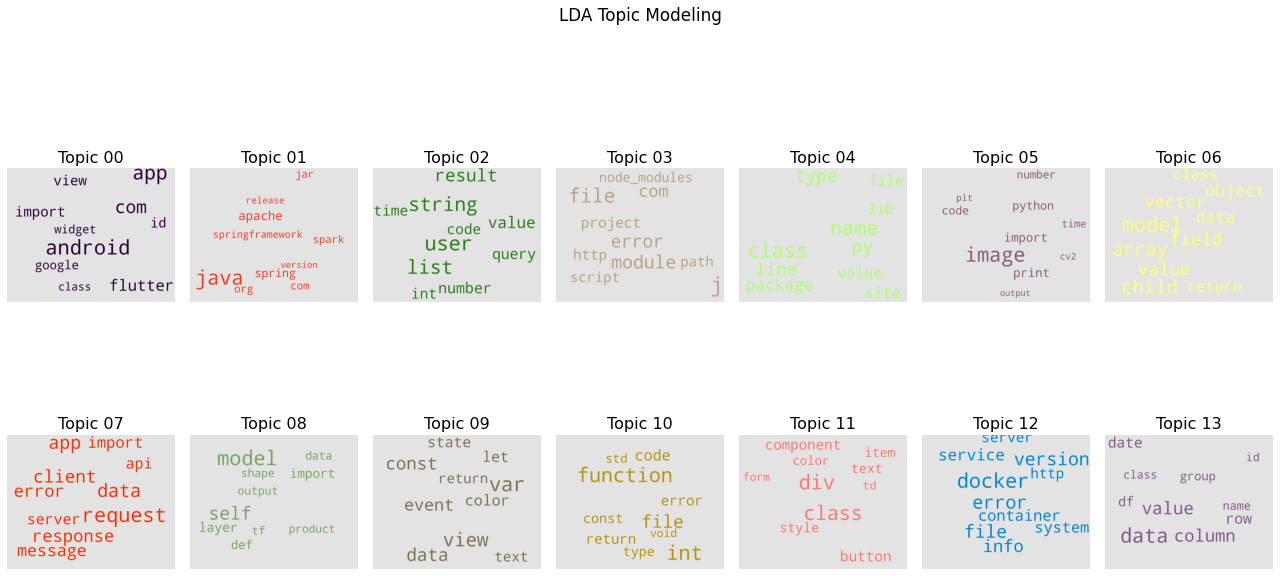

In [29]:
shuffle(colors_list)  # if a topic is hard to read
display_wordcloud(lda_model_gensim, title='LDA Topic Modeling', plot_format=(2, 7), size=(18, 10))

#### NMF

NMF produces two factor matrices as its output, **W** and **H** :
- The W factor contains the document membership weights relative to each of the k topics. Each row corresponds to a single document, and each column correspond to a topic.
- The H factor contains the term weights relative to each of the k topics. In this case, each row corresponds to a topic, and each column corresponds to a unique term in the corpus vocabulary.

**Baseline**  
Using the same number of topics as the tuned LDA

In [30]:
# same number of topics as LDA for baseline
nmf_params = {
    'corpus': tfidf_gensim,
    'num_topics': lda_params['num_topics'],
    'id2word': voc_gensim,
    'chunksize': 100,
    'eval_every': 10,
    'normalize': True,
    'random_state': 0
}
# baseline model
nmf_model_gensim = Nmf(**nmf_params)

In [31]:
# Compute Coherence Score
coherence_model_nmf = CoherenceModel(
    model=nmf_model_gensim,
    texts=bow_vectorizer.inverse_transform(vstack(corpus_df['tfidf'])),
    dictionary=voc_gensim,
    coherence='c_v',
    processes=-1
)
print('Coherence Score: ', coherence_model_nmf.get_coherence())

Coherence Score:  0.6524314232754327


**Optimal number of topics**

In [32]:
%%time
# searching a better number of topics for NMF modeling
nmf_models = compute_coherence_values(
    model_type='nmf',
    model_params=nmf_params,
    tokens=bow_vectorizer.inverse_transform(vstack(corpus_df['tfidf'])),
    start=start, limit=limit, step=step
)

Testing with 02 topics ... coherence = 0.644
Testing with 06 topics ... coherence = 0.665
Testing with 10 topics ... coherence = 0.632
Testing with 14 topics ... coherence = 0.652
Testing with 18 topics ... coherence = 0.644
Testing with 22 topics ... coherence = 0.668
Testing with 26 topics ... coherence = 0.642
Testing with 30 topics ... coherence = 0.627
Testing with 34 topics ... coherence = 0.651
Testing with 38 topics ... coherence = 0.600
Testing with 42 topics ... coherence = 0.598
Testing with 46 topics ... coherence = 0.608
Testing with 50 topics ... coherence = 0.613
Wall time: 14min 3s


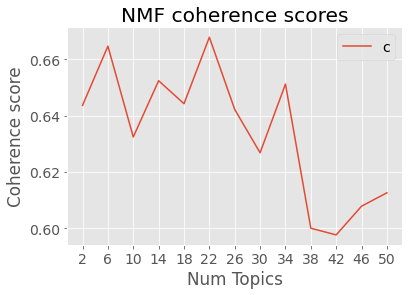

In [33]:
# Show graph
plt.plot(range(start, limit, step), [nmf_models[x]['score'] for x in nmf_models])
plt.xlabel("Num Topics")
plt.xticks(range(start, limit, step))
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title("NMF coherence scores")
plt.show()

In [34]:
best_nbtopics = [x for x in nmf_models if nmf_models[x]['score'] == max([nmf_models[x]['score'] for x in nmf_models])][0]
nmf_params['num_topics'] = best_nbtopics
print(f"As we can see, the best coherence score is reached with {best_nbtopics} topics for NMF topic modeling")

As we can see, the best coherence score is reached with 22 topics for NMF topic modeling


In [35]:
nmf_model_gensim = nmf_models[best_nbtopics]['model']
print(f"Coherence Score for {best_nbtopics} topics: {nmf_models[best_nbtopics]['score']}")

Coherence Score for 22 topics: 0.6678679995056662


In [36]:
# Saving NMF model
joblib.dump(nmf_model_gensim, "P5_04_data/gensim-nmf.pkl")

['P5_04_data/gensim-nmf.pkl']

In [37]:
for topic in nmf_model_gensim.print_topics(num_topics=best_nbtopics, num_words=10):
    print(f"Topic {topic[0]:02d} :\n{topic[1]}\n")

Topic 00 :
0.046*"button" + 0.033*"form" + 0.024*"id" + 0.024*"script" + 0.020*"input" + 0.018*"event" + 0.017*"j" + 0.015*"document" + 0.015*"html" + 0.014*"option"

Topic 01 :
0.056*"package" + 0.045*"self" + 0.031*"py" + 0.027*"site" + 0.027*"lib" + 0.025*"python3" + 0.024*"line" + 0.022*"date" + 0.012*"def" + 0.010*"__init__"

Topic 02 :
0.057*"java" + 0.025*"spring" + 0.017*"boot" + 0.014*"springframework" + 0.011*"dependency" + 0.011*"jar" + 0.010*"version" + 0.009*"org" + 0.009*"result" + 0.008*"apache"

Topic 03 :
0.047*"branch" + 0.040*"git" + 0.027*"github" + 0.025*"repository" + 0.021*"commit" + 0.021*"repo" + 0.021*"project" + 0.021*"master" + 0.013*"ssh" + 0.013*"change"

Topic 04 :
0.116*"image" + 0.033*"j" + 0.012*"node_modules" + 0.012*"img" + 0.011*"module" + 0.011*"error" + 0.010*"cv2" + 0.009*"src" + 0.009*"png" + 0.008*"webpack"

Topic 05 :
0.079*"docker" + 0.034*"container" + 0.016*"service" + 0.013*"port" + 0.011*"server" + 0.011*"host" + 0.009*"command" + 0.009*"

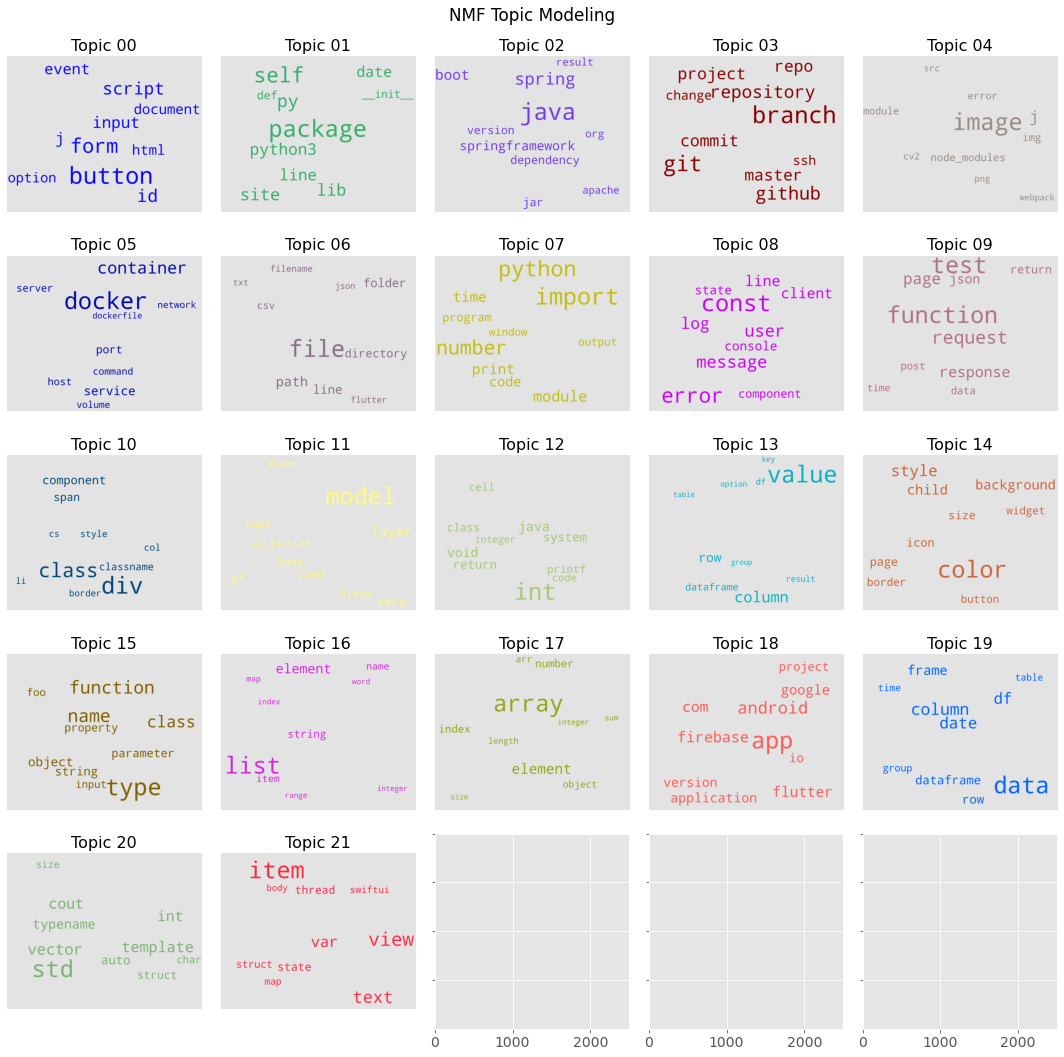

In [122]:
shuffle(colors_list)  # if a wordcloud is hard to read
display_wordcloud(nmf_model_gensim, title='NMF Topic Modeling', plot_format=(5, 5), size=(15, 15))

**The best coherence score is obtained with NMF topics modeling and 22 topics**

In [39]:
%%time
# assign topics to each doc
corpus_df['topics'] = [nmf_model_gensim.get_document_topics(bow, minimum_probability=None, normalize=None) for bow in dtm_gensim]
# remove probability from the topics
corpus_df['topics'] = corpus_df['topics'].apply(lambda x: [topic[0] for topic in x])

Wall time: 36.8 s


In [40]:
# saving dataset with computed topics
joblib.dump(corpus_df, "P5_04_data/dataset.pkl")

['P5_04_data/dataset.pkl']

In [41]:
mlb_topics = MultiLabelBinarizer()
mlb_topics.fit(corpus_df['topics'])
binary_topics = pd.DataFrame(mlb_topics.transform(corpus_df['topics']), columns=mlb_topics.classes_)

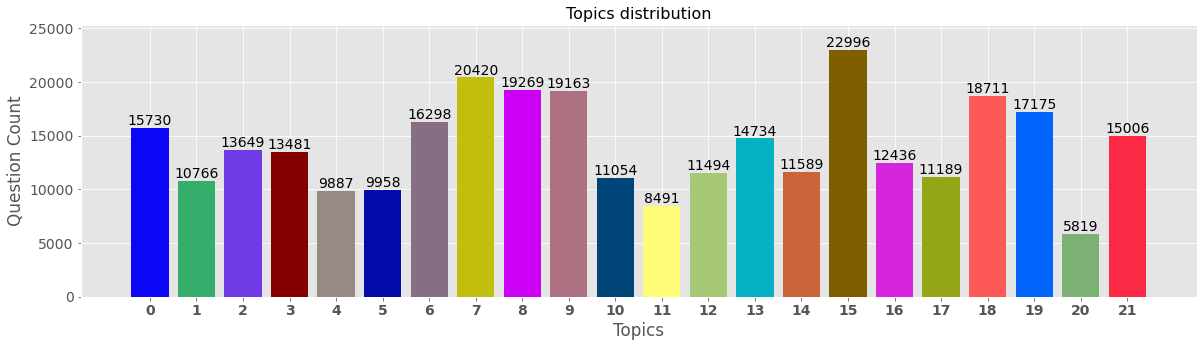

In [123]:
f, ax = plt.subplots(figsize=(20, 5))
values = binary_topics.sum()
plt.bar(x=binary_topics.columns, height=values, color=colors_list)
plt.title('Topics distribution', fontsize=16)
plt.xticks(binary_topics.columns, fontsize=14, fontweight='bold')
plt.xlabel('Topics')
plt.ylabel('Question Count')
# adding the text labels
rects = ax.patches
plt.ylim((0, max(values)+max(values)/10))
for rect, val in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, val, ha='center', va='bottom', fontsize=14)
plt.show()

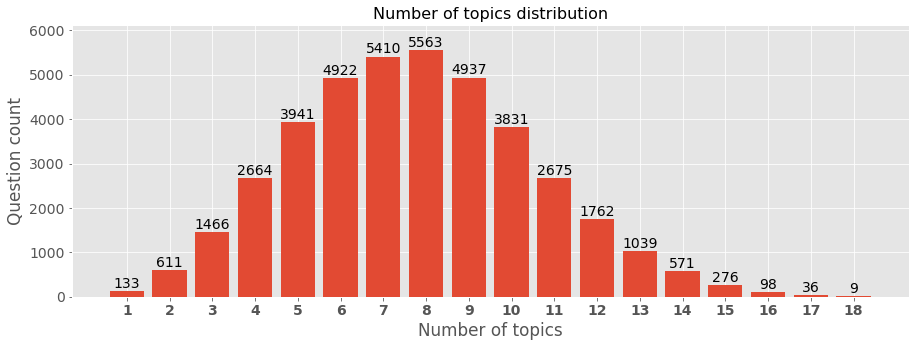

In [43]:
from collections import Counter

nbtopic_distrib = sorted(dict(Counter([len(x) for x in corpus_df['topics']])).items())
nbtopic = [x[0] for x in nbtopic_distrib]
values = [x[1] for x in nbtopic_distrib]

f, ax = plt.subplots(figsize=(15, 5))
plt.bar(x=nbtopic, height=values)
plt.title('Number of topics distribution', fontsize=16)
plt.xticks(nbtopic, fontsize=14, fontweight='bold')
plt.xlabel('Number of topics')
plt.ylabel('Question count')
# adding the text labels
rects = ax.patches

plt.ylim((0, max(values)+max(values)/10))
for rect, val in zip(rects, values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, val, ha='center', va='bottom', fontsize=14)
plt.show()

### Topics / Tags association

In [44]:
# outputs binarization
mlb_tags = MultiLabelBinarizer()
mlb_tags.fit(corpus_df['reduced_tags'])

MultiLabelBinarizer()

By multiplying the questions/topics matrix by the tags / questions matrix, its possible to obtain a tags/topics matrix which, once normalized by topics, represents the probability of each tags to belong to a topic

In [45]:
tag_doc_matrix = mlb_tags.transform(corpus_df['reduced_tags']).T
print("tag/doc matrix:", tag_doc_matrix.shape)

doc_topic_matrix = np.array(binary_topics.copy())
print("doc/topic matrix:", doc_topic_matrix.shape)


tag/doc matrix: (50, 39944)
doc/topic matrix: (39944, 22)


In [46]:
tag_topic_matrix = np.matmul(tag_doc_matrix, doc_topic_matrix)
print("tag/topic matrix:", tag_topic_matrix.shape)

tag/topic matrix: (50, 22)


In [47]:
# normalization by topics
tag_topic_matrix_norm = (tag_topic_matrix / tag_topic_matrix.sum(axis=0))

By associating each topic with the tag having the greatest probability we obtain the following associations

In [48]:
tag_topic_associations = dict(pd.DataFrame(
    tag_topic_matrix_norm,
    index=mlb_tags.classes_,
    columns=mlb_topics.classes_
).idxmax(axis=0))
tag_topic_associations

{0: 'javascript',
 1: 'python',
 2: 'java',
 3: 'python',
 4: 'javascript',
 5: 'python',
 6: 'python',
 7: 'python',
 8: 'javascript',
 9: 'python',
 10: 'javascript',
 11: 'python',
 12: 'java',
 13: 'python',
 14: 'python',
 15: 'python',
 16: 'python',
 17: 'python',
 18: 'python',
 19: 'python',
 20: 'c++',
 21: 'python'}

In [49]:
corpus_df['method1_tags'] = corpus_df['topics'].apply(lambda x: list(map(tag_topic_associations.get, x)))
# removing duplicates
corpus_df['method1_tags'] = corpus_df['method1_tags'].apply(lambda x: list(set(x)))

In [51]:
y = mlb_tags.transform(corpus_df['reduced_tags'])
y_preds = mlb_tags.transform(corpus_df['method1_tags'])
print(classification_report(y, y_preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       579
           1       0.00      0.00      0.00       771
           2       0.00      0.00      0.00      2316
           3       0.00      0.00      0.00       941
           4       0.00      0.00      0.00       493
           5       0.00      0.00      0.00       628
           6       0.00      0.00      0.00       454
           7       0.00      0.00      0.00       578
           8       0.00      0.00      0.00       617
           9       0.00      0.00      0.00      1828
          10       0.30      0.80      0.44      2205
          11       0.00      0.00      0.00      1120
          12       0.00      0.00      0.00       730
          13       0.00      0.00      0.00       776
          14       0.00      0.00      0.00       683
          15       0.00      0.00      0.00      1050
          16       0.00      0.00      0.00       716
          17       0.00    

In [120]:
m1_tags_cnt = corpus_df['method1_tags'].apply(tuple).value_counts().sort_values(ascending=True)

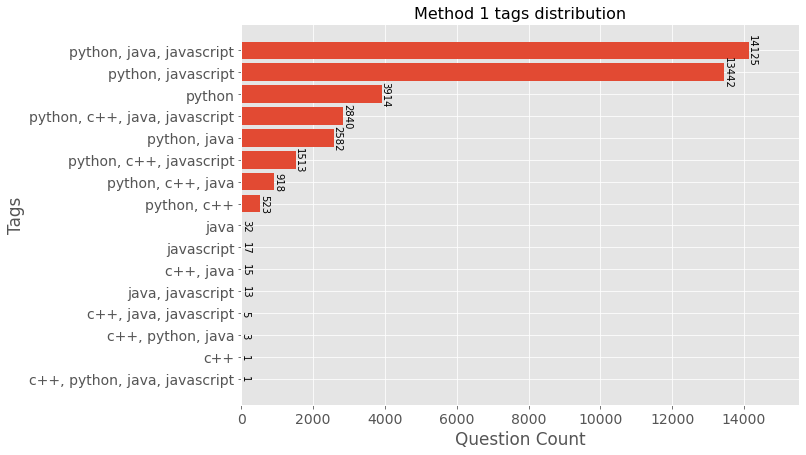

In [119]:
f, ax = plt.subplots(figsize=(10, 7))
labels = [", ".join(x) for x in m1_tags_cnt.index]
plt.barh(labels, m1_tags_cnt)
plt.title('Method 1 tags distribution', fontsize=16)
plt.yticks(fontsize=14)
plt.ylabel('Tags')
plt.xlabel('Question Count')
# adding the text labels
rects = ax.patches
plt.xlim((0, max(m1_tags_cnt)+max(m1_tags_cnt)/10))
for rect, val in zip(rects, m1_tags_cnt):
    width = rect.get_width()
    ax.text(width + 100, rect.get_y() + rect.get_height()/2, val, ha='center', va='center', fontsize=10, rotation=-90)
plt.show()

## Method 2 : supervised classification

In [5]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(corpus_df['doc'], corpus_df['reduced_tags'], random_state=0, test_size=0.33, shuffle=True)

In [6]:
%%time
# Inputs vectorization
X_train_vect = tfidf_vectorizer.fit_transform(X_train)
X_test_vect = tfidf_vectorizer.transform(X_test)

mlb_tags = MultiLabelBinarizer(sparse_output=True)
y_train_vect = mlb_tags.fit_transform(y_train)
y_test_vect = mlb_tags.transform(y_test)

joblib.dump((tfidf_vectorizer, mlb_tags), "P5_04_data/trainset-io-vectorizers.pkl")
joblib.dump((X_train_vect, X_test_vect, y_train_vect, y_test_vect), "P5_04_data/classifiers-datasets.pkl")

Wall time: 10min 4s


['P5_04_data/classifiers-datasets.pkl']

In [7]:
print(X_train_vect.shape, y_train_vect.shape, X_test_vect.shape, y_test_vect.shape)

(26762, 13264) (26762, 50) (13182, 13264) (13182, 50)


I'm not using a pipeline to save time on document vectorization during the classification tests

In [7]:
tfidf_vectorizer, mlb_tags = joblib.load("P5_04_data/trainset-io-vectorizers.pkl")
X_train_vect, X_test_vect, y_train_vect, y_test_vect = joblib.load("P5_04_data/classifiers-datasets.pkl")

### One Vs Rest

A “one-Vs-rest” strategy, builds multiple independent classifiers and, for an unseen instance, choose the class for which the confidence is maximized.  
The main assumption here is that the labels are mutually exclusive. You do not consider any underlying correlation between the classes in this method.

In [7]:
# used scoring metric
metrics = ['f1_macro', 'jaccard_macro']


def gs_tuning(classifier, params_grid, filename,
              trainset=(X_train_vect, y_train_vect), testset=(X_test_vect, y_test_vect),  metrics=metrics, save=True):
    """
    args:
        classifier (obj) - classifier to optimize
        params_grid (dict) - tested parameters
        trainset (tuple) - X_train, y_train in a tuple
        testset (tuple) - X_test, y_test in a tuple
        metric (list or str) - scoring metrics
        save (bool) - save best model if True
    returns:
        best_model (obj) - tuned model
        preds (list) - best model predictions
    """
    gd = GridSearchCV(classifier, params_grid, scoring=metrics, refit=metrics[0], return_train_score=True, n_jobs=-1)
    gd.fit(trainset[0], trainset[1])
    print(f"Best params: {gd.best_params_}")
    print(f"Best training F1: {gd.best_score_}")
    preds = gd.predict(testset[0])
    print(f"Scores on testset: F1={f1_score(testset[1], preds, average='macro'):.3f}"
          f" - Jaccard={jaccard_score(testset[1], preds, average='macro'):.3f}\n")
    print(classification_report(testset[1], preds, zero_division=0))
    if save:
        joblib.dump(gd.best_estimator_, f"P5_04_data/model-{filename}-tuned.pkl")
    return gd.best_estimator_, preds


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


#### LinearSVC

In [8]:
%%time

ovr_svc = OneVsRestClassifier(LinearSVC(random_state=0), n_jobs=-1)
ovr_svc.fit(X_train_vect, y_train_vect)

ovr_svc_preds = ovr_svc.predict(X_test_vect)

print("OneVsRestClassifier - Linear SVC on testset :")
print(f"F1={f1_score(y_test_vect, ovr_svc_preds, average='macro'):.3f} - Jaccard={jaccard_score(y_test_vect, ovr_svc_preds, average='macro'):.3f}")
print(classification_report(y_test_vect, ovr_svc_preds, zero_division=0))

OneVsRestClassifier - Linear SVC on testset :
F1=0.626 - Jaccard=0.479
              precision    recall  f1-score   support

           0       0.68      0.38      0.49       183
           1       0.84      0.59      0.69       264
           2       0.89      0.65      0.75       786
           3       0.91      0.41      0.56       301
           4       0.91      0.65      0.76       161
           5       0.52      0.20      0.29       208
           6       0.69      0.37      0.48       150
           7       0.83      0.61      0.71       190
           8       0.75      0.47      0.58       194
           9       0.83      0.50      0.62       579
          10       0.90      0.71      0.79       730
          11       0.78      0.59      0.67       372
          12       0.53      0.33      0.41       242
          13       0.52      0.17      0.25       280
          14       0.94      0.72      0.82       221
          15       0.95      0.78      0.85       376
          

#### RandomForestClassifier

In [10]:
# disable warning for bad combinaisons in the GridSearch
warnings.filterwarnings('ignore')

In [11]:
%%time
ovr_rf_params = {
    'estimator__n_estimators': [100, 200],
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [None, '1'],
}
tuned_ovr_rf, ovr_rf_preds = gs_tuning(OneVsRestClassifier(RandomForestClassifier(random_state=0), n_jobs=-1), ovr_rf_params, filename="ovr-rf")

Best params: {'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__n_estimators': 100}
Best training F1: 0.4231060667227388
Scores on testset: F1=0.453 - Jaccard=0.335

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       183
           1       0.84      0.41      0.55       264
           2       0.90      0.60      0.72       786
           3       0.99      0.36      0.52       301
           4       0.90      0.58      0.71       161
           5       1.00      0.00      0.01       208
           6       0.78      0.09      0.17       150
           7       0.96      0.13      0.23       190
           8       0.90      0.14      0.25       194
           9       0.85      0.36      0.51       579
          10       0.96      0.64      0.77       730
          11       0.85      0.27      0.41       372
          12       0.68      0.11      0.19       242
          13       1.00      0.00      0.01       280

#### LogisticRegression

In [ ]:
%%time

ovr_lr_params = {
    'estimator__solver': ['sag', 'saga'],  # faster on large dataset
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__penalty': ['l1', 'l2', None, 'elasticnet'],
}

tuned_ovr_lr, ovr_lr_preds = gs_tuning(OneVsRestClassifier(LogisticRegression(), n_jobs=-1), ovr_lr_params, filename="ovr-lr")

### Classifier Chain

A chain of binary classifiers C_0, C_1, . . . , C_n is constructed, where a classifier C_i uses the predictions of all the classifier C_j , where j < i.   
This way the classifier chains method can take into account label correlations.  
The total number of classifiers needed for this approach is equal to the number of classes, but the training of the classifiers is more involved. 

#### LogisticRegression

In [ ]:
%%time
# classifier chains multi-label classifier
cc_lr_base = ClassifierChain(LogisticRegression(
    solver='saga',
    C=10,
    penalty='l1',
    max_iter=100,
    n_jobs=-1,
    random_state=0
), order='random', random_state=0)
cc_lr_base.fit(X_train_vect, y_train_vect)
# predict
cc_preds = cc_lr_base.predict(X_test_vect)

print(f"ClassifierChain on testset : F1={f1_score(y_test_vect, cc_preds, average='macro'):.3f}"
      f" - Jaccard={jaccard_score(y_test, cc_preds, average='macro'):.3f}")
joblib.dump(cc_lr_base, "P5_04_data/model-ClassifierChain.pkl")

I directly use the same parameters as for the previous tuned LogisticRegression because the optimization by GridSearch of the ClassifierChain requires too much time and memory.

**Optimizations**

In [ ]:
%%time
# ClassifierChain using LogisticRegression
cc_lr_params = {
    'classifier__solver': ['sag', 'saga'],
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2', None],
    'classifier__max_iter': [100, 200],
}

# tuned_cc_lr, cc_preds = gs_tuning(ClassifierChain(LogisticRegression()), cc_lr_params)

In [ ]:
# re-enable warnings
# warnings.filterwarnings('always')

### Universal Sentence Encoder tests

In [26]:
import tensorflow_hub as hub

use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

embeddings_train = use_model(X_train)
embeddings_test = use_model(X_test)

tf.Tensor(
[[-0.03133018 -0.06338634 -0.016075   ... -0.03242778 -0.0457574
   0.05370456]
 [ 0.05080861 -0.01652429  0.0157378  ...  0.00976658  0.03170122
   0.01788118]], shape=(2, 512), dtype=float32)


In [29]:
joblib.dump((embeddings_train, embeddings_test), "P5_04_data/train_test_embeddings.pkl")

tensorflow.python.framework.ops.EagerTensor

In [41]:
%%time

tuned_ovr_lr_use, ovr_lr_use_preds = gs_tuning(OneVsRestClassifier(RandomForestClassifier(random_state=0)n_jobs=-1), ovr_rf_params, filename="ovr-rf", trainset=(np.array(embeddings_train), y_train_vect), testset=(np.array(embeddings_test), y_test_vect))

C:\Users\Flooow\anaconda3\envs\OC_IML_P5\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.12772976 0.1386477  0.1386507         nan        nan
        nan        nan        nan 0.55457569 0.52170014 0.52174196
        nan        nan        nan        nan        nan 0.61866217
 0.61632014 0.61662248        nan        nan        nan        nan
        nan 0.58846476 0.61599454 0.61683556        nan        nan
        nan        nan]
  warnings.warn(
C:\Users\Flooow\anaconda3\envs\OC_IML_P5\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the train scores are non-finite: [       nan 0.12824785 0.14141888 0.14144514        nan        nan
        nan        nan        nan 0.58605696 0.55084852 0.55106961
        nan        nan        nan        nan        nan 0.74507781
 0.69336983 0.69363215        nan        nan        nan        nan
        nan 0.81014066 0.7720952  0.7

Best params: {'estimator__C': 10, 'estimator__max_iter': 300, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}
Best training F1: 0.6186621684672071
Scores on testset: F1=0.626 - Jaccard=0.475

              precision    recall  f1-score   support

           0       0.71      0.55      0.62       183
           1       0.78      0.67      0.72       264
           2       0.83      0.73      0.77       786
           3       0.86      0.63      0.73       301
           4       0.86      0.66      0.75       161
           5       0.53      0.24      0.33       208
           6       0.49      0.32      0.39       150
           7       0.80      0.58      0.68       190
           8       0.75      0.56      0.64       194
           9       0.79      0.66      0.72       579
          10       0.88      0.77      0.82       730
          11       0.77      0.67      0.71       372
          12       0.50      0.27      0.35       242
          13       0.41      0.18      0.2

In [45]:
%%time
# classifier chains multi-label classifier
ovr_lr_use = OneVsRestClassifier(LogisticRegression(
    solver='saga',
    C=10,
    penalty='l1',
    max_iter=100,
    n_jobs=-1,
    random_state=0
))
ovr_lr_use.fit(embeddings_train, y_train_vect)
# predict
ovr_lr_use_preds = ovr_lr_use.predict(embeddings_test)

print(f"ClassifierChain on testset : F1={f1_score(y_test_vect, ovr_lr_use_preds, average='macro'):.3f}"
      f" - Jaccard={jaccard_score(embeddings_test, ovr_lr_use_preds, average='macro'):.3f}")
joblib.dump(ovr_lr_use, "P5_04_data/model-OneVsRest_USEdata.pkl")

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets

In [70]:
pd.DataFrame(ovr_lr_use_preds)

,0
0,"(0, 36)\t1"
1,"(0, 11)\t1\n (0, 21)\t1"
2,"(0, 10)\t1"
3,"(0, 7)\t1"
4,
...,...
13177,"(0, 33)\t1"
13178,"(0, 32)\t1"
13179,"(0, 9)\t1"
13180,"(0, 16)\t1\n (0, 38)\t1"


In [23]:
%%time
from sklearn.svm import LinearSVC

ovr_svc = OneVsRestClassifier(LinearSVC(random_state=0), n_jobs=-1)
ovr_svc.fit(embeddings_train, y_train_vect)

ovr_svc_preds = ovr_svc.predict(embeddings_test)

print("OneVsRestClassifier - Linear SVC on testset with USE :")
print(f"F1={f1_score(y_test_vect, ovr_svc_preds, average='weighted'):.3f} - Jaccard={jaccard_score(y_test_vect, ovr_svc_preds, average='weighted'):.3f}")
print(classification_report(y_test_vect, ovr_lr_preds, zero_division=0))

NameError: name 'ovr_lr_params' is not defined

In [42]:
print(1)

1
